### Prepare data

a bunch of sine waves with different trends, but same frequencies and phases


In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pathlib
import random
import sklearn.linear_model
import torch
import torch.nn as nn
from torch.nn.modules.transformer import MultiheadAttention
from torch.optim.lr_scheduler import LambdaLR

#import utils
#import importlib
#_ = importlib.reload(utils)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


No GPU -> using CPU: cpu


/home/markus/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
num_datasets=50
num_features=1                      # stick to univariate data right now
num_points_in_each_dataset=512+96   # fit for TTM 512_96

# for later tuning
hyperparameters = {'output_noise': 0.01, 'variance_weights': 1.0, 'scaling': .5}
    
ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['variance_weights']).sample((num_datasets,))
ws[0] = torch.Tensor([0,0])
# shape (50,2) normally distributed around mean 0

#xs = torch.rand(num_datasets, num_points_in_each_dataset, num_features)

xs = torch.meshgrid(torch.arange(num_datasets, dtype=torch.float), 
                    torch.arange(0, np.pi, step=np.pi/num_points_in_each_dataset, dtype=torch.float),
                    torch.arange(num_features, dtype=torch.float))[1]

# concat meshgrid with 1-matrix - elementwise xs*ws[0](slope) + ws[1](constant) for each of the 50 datasets
xxxs =  torch.einsum('nmf, nf -> nm',
                 torch.cat([xs, torch.ones(num_datasets, num_points_in_each_dataset,1)], 2),
                 ws
                )

'''
# Don't need it now
ys = torch.distributions.Normal(
    torch.einsum('nmf, nf -> nm',
                 torch.cat([xs, torch.ones(num_datasets, num_points_in_each_dataset,1)], 2),
                 ws
                ),
    hyperparameters['output_noise']
).sample()
'''

zs = xxxs + torch.sin(xs[...,0]*17) * hyperparameters['scaling']
#zs = zs.diff()

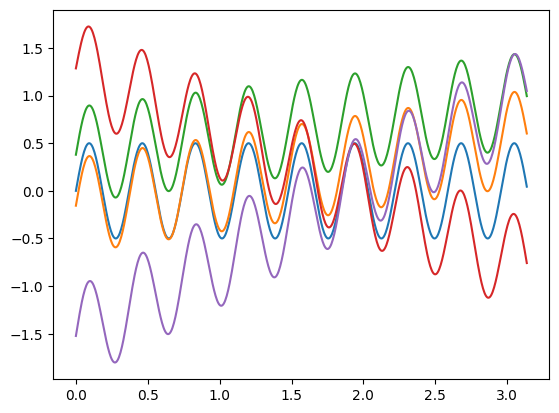

In [5]:
for dataset_index in range(5): #range(num_datasets):
    plt.plot(xs[dataset_index,:,0].numpy(), zs[dataset_index].numpy()) #, s=0.8)

### Try with TTM first

In [45]:
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", cache_dir='/tmp', revision="main")

2025-02-20 09:30:06.716168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740040206.764091 2582063 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740040206.778755 2582063 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 09:30:06.827050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
# I'm not sure whether this is the right way to specify frequency patterns for TTM 

freq = torch.sin(xs[...,0]*17)[0]

# and the public model doesn't support it as you can see
model.decoder.resolution_prefix_tuning, model.backbone.encoder.resolution_prefix_tuning

(False, False)

In [46]:
#zs = zs.diff()
#zhat = model(zs[:,:512,None], freq_token=freq)['prediction_outputs']
zhat = model(zs[:,:512,None])['prediction_outputs']

In [51]:
from cbm_gen.utils.benchmarks.evaluation import trend_loss, tildeq_loss
loss_trend = trend_loss(zhat.squeeze(), zs[:,512:])
loss_tildeq = tildeq_loss(zhat.squeeze(), zs[:,512:])

In [55]:
# find the best and worst match according to TildeQ - usually trend and tilde-q agree
bad_idx = loss_tildeq.argmax()
good_idx = loss_tildeq.argmin()
bad_idx, good_idx, loss_trend.argmax(), loss_trend.argmin()
# surprisingly the plain sine wave is doing less well than a sine wave with a very slight trend

(tensor(38), tensor(31), tensor(38), tensor(37))

In [57]:
ws[good_idx], ws[bad_idx]

(tensor([-0.0529, -1.7077]), tensor([-2.2462,  1.2485]))

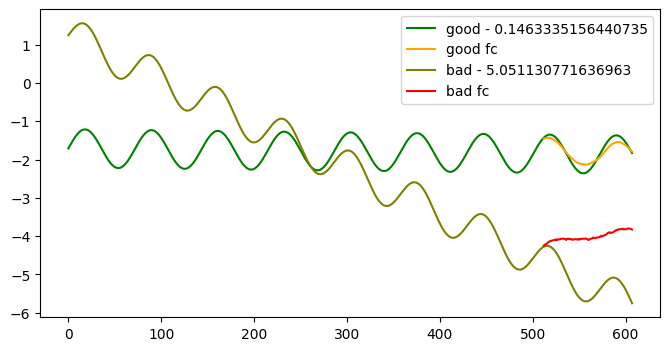

In [85]:
#good_idx = 11
#bad_idx = 1
tpl = np.zeros(512).reshape(-1,1)
tpl[:] = np.nan
good = np.vstack((tpl,zhat[good_idx].detach().numpy()))
bad = np.vstack((tpl,zhat[bad_idx].detach().numpy()))

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(range(512+96), zs[good_idx,:].detach().numpy(), label='good - ' + str(loss_trend[good_idx].detach().item()),c='g')
ax.plot(range(512+96), good, label='good fc', c='orange')
ax.plot(range(512+96), zs[bad_idx,:].detach().numpy(), label='bad - ' + str(loss_trend[bad_idx].detach().item()), c='olive')
ax.plot(range(512+96), bad, label='bad fc', c='red')
ax.legend()

In [59]:
#plt.plot(zhat[bad_idx].detach().numpy())
#plt.plot(zs[bad_idx,512:].detach().numpy())

In [60]:
'''
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(range(96), zs[0,512:].detach().numpy(), label='Example Forecast0', c='black')
ax.plot(range(96), zhat[0].detach().numpy(), label='Example GroundTruth0', c='black')

for dataset_index in range(10):
    ax.plot(range(96), zhat[dataset_index].squeeze().detach().numpy() - zs[dataset_index,512:].detach().numpy(),
             label='loss[' + str(dataset_index) + ']  ' + str(loss_trend[dataset_index].detach().item()))
             
ax.plot(range(96), zhat[33].squeeze().detach().numpy() - zs[33,512:].detach().numpy(),
             label='loss[' + str(33) + ']  ' + str(loss_trend[33].detach().item()))
ax.legend()
'''


"\nfig, ax = plt.subplots(1,1,figsize=(10,5))\nax.plot(range(96), zs[0,512:].detach().numpy(), label='Example Forecast0', c='black')\nax.plot(range(96), zhat[0].detach().numpy(), label='Example GroundTruth0', c='black')\n\nfor dataset_index in range(10):\n    ax.plot(range(96), zhat[dataset_index].squeeze().detach().numpy() - zs[dataset_index,512:].detach().numpy(),\n             label='loss[' + str(dataset_index) + ']  ' + str(loss_trend[dataset_index].detach().item()))\n             \nax.plot(range(96), zhat[33].squeeze().detach().numpy() - zs[33,512:].detach().numpy(),\n             label='loss[' + str(33) + ']  ' + str(loss_trend[33].detach().item()))\nax.legend()\n"

### TabPFN

In [13]:
import torch
from tabpfn import TabPFNClassifier, TabPFNRegressor

#### Prepare data

TabPFN is no true time series model, but expects tabular data. To handle time series it needs a running index and numerical features to express periodicity (such as hour_of_day).
Data is expected to be presented in pandas frames with a multi-index and certain column names.
Data to be forecasted needs to be present in column 'target' which has to be NaN for the test data.

In [23]:
offset = 512
horizon = 96
zss = zs.detach().numpy()
df_train = pd.DataFrame(columns=['item_id', 'timestamp', 'target'])
df_test = pd.DataFrame(columns=['item_id', 'timestamp', 'target'])
df_gt = pd.DataFrame(columns=['item_id', 'timestamp', 'target'])

for i in range(zss.shape[0]):
    tt = pd.date_range(start='2020-01-01', periods=offset+horizon, freq='1h')
    df_i = pd.DataFrame({'item_id': i, 'target': zs[i][512-offset:512], 'timestamp': tt[:offset]})
    df_j = pd.DataFrame({'item_id': i, 'target': np.nan, 'timestamp': tt[offset:]})
    df_k = pd.DataFrame({'item_id': i, 'target': zs[i][512:512+horizon], 'timestamp': tt[offset:]})
    #print(df_k)
    df_train = pd.concat([df_train, df_i], ignore_index=True)
    df_test = pd.concat([df_test, df_j], ignore_index=True)
    df_gt = pd.concat([df_gt, df_k], ignore_index=True)
    #print(df_gt)

/tmp/ipykernel_2645774/1096665113.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train = pd.concat([df_train, df_i], ignore_index=True)
/tmp/ipykernel_2645774/1096665113.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, df_j], ignore_index=True)
/tmp/ipykernel_2645774/1096665113.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns

In [24]:
# multi-index
df_train = df_train.set_index(['item_id','timestamp'])
df_test = df_test.set_index(['item_id','timestamp'])
df_gt = df_gt.set_index(['item_id','timestamp'])

#pd.DataFrame({'target': zss[0][512-163:512], 'timestamp': pd.date_range(start='2020-01-01', periods=163)})

In [16]:
# use a helper class to generate calendar features
from tabpfn_time_series import FeatureTransformer, DefaultFeatures

selected_features = [
    DefaultFeatures.add_running_index,
    DefaultFeatures.add_calendar_features,
]
df_Train, df_Test = FeatureTransformer.add_features(df_train, df_test, selected_features)


/home/markus/.local/lib/python3.12/site-packages/tabpfn_time_series/feature.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, test_tsdf])


In [17]:
# removing superfluous features
df_Train = df_Train.drop(columns=['year','month_of_year_sin','month_of_year_cos',
                                  'day_of_year_sin', 'day_of_year_sin', 'week_of_year_sin', 'week_of_year_cos'])
df_Test = df_Test.drop(columns=['year','month_of_year_sin','month_of_year_cos',
                                'day_of_year_sin', 'day_of_year_sin', 'week_of_year_sin', 'week_of_year_cos'])

In [18]:
'''
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,
)
train_X = train_tsdf
train_y = train_tsdf

pred = predictor.predict(train_X,train_y.drop(columns=['target']))
'''

"\nfrom tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode\n\npredictor = TabPFNTimeSeriesPredictor(\n    tabpfn_mode=TabPFNMode.LOCAL,\n)\ntrain_X = train_tsdf\ntrain_y = train_tsdf\n\npred = predictor.predict(train_X,train_y.drop(columns=['target']))\n"

In [19]:
df_Train.columns

Index(['target', 'running_index', 'hour_of_day_sin', 'hour_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_cos'],
      dtype='object')

In [20]:
n = 8
y_pred_reg = TabPFNRegressor(random_state=42, fit_mode="low_memory", 
                             ignore_pretraining_limits=True).fit(df_Train.loc[n:n], df_Train.loc[n:n]['target'])

Ensemble_configs [RegressorEnsembleConfig(preprocess_config=PreprocessorConfig(name='quantile_uni', categorical_name='ordinal_very_common_categories_shuffled', append_original=True, subsample_features=-1, global_transformer_name='svd'), add_fingerprint_feature=True, polynomial_features='no', feature_shift_count=780, feature_shift_decoder='shuffle', subsample_ix=None, target_transform=None), RegressorEnsembleConfig(preprocess_config=PreprocessorConfig(name='quantile_uni', categorical_name='ordinal_very_common_categories_shuffled', append_original=True, subsample_features=-1, global_transformer_name='svd'), add_fingerprint_feature=True, polynomial_features='no', feature_shift_count=774, feature_shift_decoder='shuffle', subsample_ix=None, target_transform=None), RegressorEnsembleConfig(preprocess_config=PreprocessorConfig(name='quantile_uni', categorical_name='ordinal_very_common_categories_shuffled', append_original=True, subsample_features=-1, global_transformer_name='svd'), add_fingerp

In [21]:
from tabpfn_time_series.defaults import TABPFN_TS_DEFAULT_QUANTILE_CONFIG
quantile_config = TABPFN_TS_DEFAULT_QUANTILE_CONFIG

y_pred = y_pred_reg.predict(df_Test.loc[n:n], output_type="main")

Config RegressorEnsembleConfig(preprocess_config=PreprocessorConfig(name='quantile_uni', categorical_name='ordinal_very_common_categories_shuffled', append_original=True, subsample_features=-1, global_transformer_name='svd'), add_fingerprint_feature=True, polynomial_features='no', feature_shift_count=780, feature_shift_decoder='shuffle', subsample_ix=None, target_transform=None)
Preprocessor [<tabpfn.model.preprocessing.RemoveConstantFeaturesStep object at 0x79e04855f6b0>, <tabpfn.model.preprocessing.ReshapeFeatureDistributionsStep object at 0x79dff8924d70>, <tabpfn.model.preprocessing.EncodeCategoricalFeaturesStep object at 0x79dff89250a0>, <tabpfn.model.preprocessing.AddFingerprintFeaturesStep object at 0x79dff8924fe0>, <tabpfn.model.preprocessing.ShuffleFeaturesStep object at 0x79dff89252b0>]
XFull <class 'torch.Tensor'> torch.Size([608, 1, 23])
ytrain <class 'torch.Tensor'> torch.Size([512])
Output torch.Size([96, 1, 5000])
Config RegressorEnsembleConfig(preprocess_config=Preproces

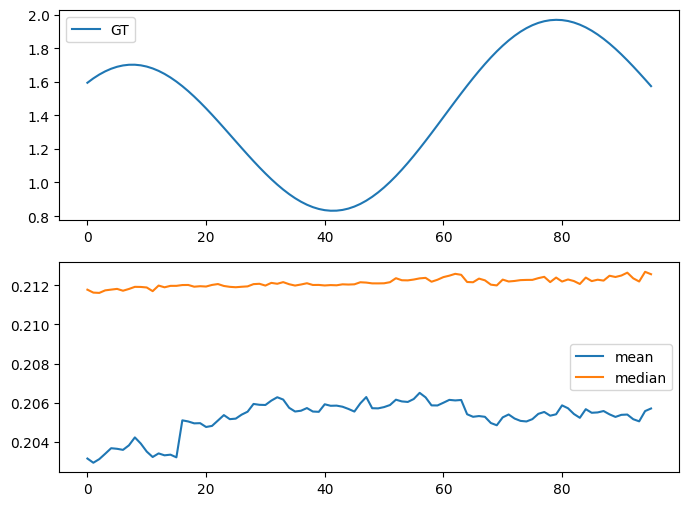

In [22]:
fig,ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(df_gt.loc[n]['target'].values, label='GT')

ax[1].plot(y_pred['mean'], label='mean')
ax[1].plot(y_pred['median'], label='median')
#ax[1].plot(y_pred['quantiles'][0], label='lowest quantile')
#ax[1].plot(y_pred['quantiles'][8], label='highest quantile')

ax[0].legend()
ax[1].legend()

### Trying the official repo for their NeurIPS 2024 contrib

https://github.com/liam-sbhoo/tabpfn-time-series

Just to compare with 'manual results' which apparently miss the inverse transformations

In [39]:
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame

tsdf = TimeSeriesDataFrame(df_train)
print(tsdf.loc[0].shape)
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=60)


from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X
'''
prediction_length = dataset_metadata[dataset_choice]['prediction_length']
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)
'''
test_tsdf = generate_test_X(train_tsdf, 60)

(512, 1)


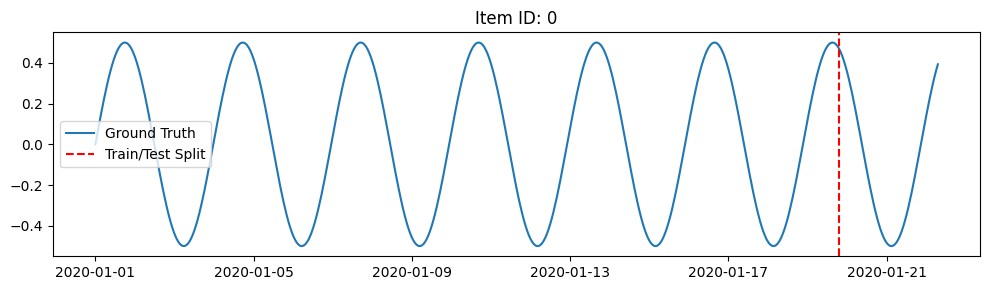

In [43]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf.loc[0:0], test_tsdf_ground_truth.loc[0:0])

In [44]:
from tabpfn_time_series import FeatureTransformer, DefaultFeatures

selected_features = [
    DefaultFeatures.add_running_index,
    DefaultFeatures.add_calendar_features,
]

train_tsdf, test_tsdf = FeatureTransformer.add_features(
    train_tsdf, test_tsdf, selected_features
)

/home/markus/.local/lib/python3.12/site-packages/tabpfn_time_series/feature.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, test_tsdf])


In [46]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,
)

pred = predictor.predict(train_tsdf.loc[0:0], test_tsdf.loc[0:0])



GPU 0::   0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Ensemble_configs [RegressorEnsembleConfig(preprocess_config=PreprocessorConfig(name='quantile_uni', categorical_name='ordinal_very_common_categories_shuffled', append_original=True, subsample_features=-1, global_transformer_name='svd'), add_fingerprint_feature=True, polynomial_features='no', feature_shift_count=636, feature_shift_decoder='shuffle', subsample_ix=None, target_transform=None), RegressorEnsembleConfig(preprocess_config=PreprocessorConfig(name='quantile_uni', categorical_name='ordinal_very_common_categories_shuffled', append_original=True, subsample_features=-1, global_transformer_name='svd'), add_fingerprint_feature=True, polynomial_features='no', feature_shift_count=637, feature_shift_decoder='shuffle', subsample_ix=None, target_transform=None), RegressorEnsembleConfig(preprocess_config=PreprocessorConfig(name='quantile_uni', categorical_name='ordinal_very_common_categories_shuffled', append_original=True, subsample_features=-1, global_transformer_name='svd'), add_fingerp

/home/markus/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/markus/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/markus/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/markus/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
GPU 0:: 100%|███████████████████████████████████████████████████

In [53]:
pred.loc[0:0]

target       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2020-01-19 20:00:00  0.455230  0.440692  0.448417  0.451748  0.453483   
        2020-01-19 21:00:00  0.438342  0.377281  0.414398  0.426713  0.433894   
        2020-01-19 22:00:00  0.419660  0.278426  0.366553  0.396212  0.409680   
        2020-01-19 23:00:00  0.392647  0.199157  0.300279  0.348204  0.374034   
        2020-01-20 00:00:00  0.352387 -0.289382  0.052554  0.147924  0.256149   
        2020-01-20 01:00:00  0.304486 -0.328162  0.024253  0.122434  0.202927   
        2020-01-20 02:00:00  0.265998 -0.336010  0.001646  0.119352  0.190552   
        2020-01-20 03:00:00  0.265440 -0.339757 -0.028926  0.121078  0.196444   
        2020-01-20 04:00:00  0.280317 -0.325821 -0.016338  0.136242  0.215817   
        2020-01-20 05:00:00  0.292498 -0.297344  0.025169  0.155019  0.232881   
        2020-01-20 06:00:00  0.302041 -0.293638  0.038435  0.160384  0.242387   
        2020-01-20 07:00:00  0.320025 -0.322534  0.013328  0.145831  0.246108   
        2020-01-20 08:00:00  0.338067 -0.354872 -0.048617  0.118339  0.236844   
        2020-01-20 09:00:00  0.362589 -0.366335 -0.056504  0.109335  0.240088   
        2020-01-20 10:00:00  0.384321 -0.378933 -0.063650  0.103244  0.247882   
        2020-01-20 11:00:00  0.407364 -0.385155 -0.064121  0.103245  0.268715   
        2020-01-20 12:00:00  0.424442 -0.387290 -0.074414  0.095892  0.273902   
        2020-01-20 13:00:00  0.425312 -0.394097 -0.109672  0.076133  0.250710   
        2020-01-20 14:00:00  0.439144 -0.383886 -0.097730  0.089807  0.279395   
        2020-01-20 15:00:00  0.440723 -0.379247 -0.103040  0.092804  0.290065   
        2020-01-20 16:00:00  0.444890 -0.378516 -0.113368  0.100642  0.315555   
        2020-01-20 17:00:00  0.452460 -0.364332 -0.065320  0.141703  0.363517   
        2020-01-20 18:00:00  0.444846 -0.370481 -0.064023  0.143213  0.358949   
        2020-01-20 19:00:00  0.427595 -0.385168 -0.094186  0.115621  0.327417   
        2020-01-20 20:00:00  0.399904 -0.389501 -0.112871  0.086141  0.271014   
        2020-01-20 21:00:00  0.363870 -0.393744 -0.135778  0.058177  0.208942   
        2020-01-20 22:00:00  0.334515 -0.394462 -0.142517  0.049549  0.176861   
        2020-01-20 23:00:00  0.294356 -0.391740 -0.132671  0.057558  0.165415   
        2020-01-21 00:00:00  0.169289 -0.440868 -0.325433 -0.109832  0.053455   
        2020-01-21 01:00:00  0.166494 -0.446401 -0.323564 -0.108130  0.060303   
        2020-01-21 02:00:00  0.165753 -0.450030 -0.318968 -0.112218  0.064372   
        2020-01-21 03:00:00  0.169582 -0.449179 -0.314527 -0.121157  0.068757   
        2020-01-21 04:00:00  0.181956 -0.436743 -0.296302 -0.115152  0.079854   
        2020-01-21 05:00:00  0.182665 -0.429342 -0.294995 -0.120277  0.082162   
        2020-01-21 06:00:00  0.179541 -0.433910 -0.305527 -0.132472  0.076571   
        2020-01-21 07:00:00  0.169699 -0.450053 -0.335662 -0.173805  0.050740   
        2020-01-21 08:00:00  0.149317 -0.464507 -0.372887 -0.214243  0.015844   
        2020-01-21 09:00:00  0.131142 -0.466341 -0.390006 -0.237257 -0.010515   
        2020-01-21 10:00:00  0.123325 -0.462307 -0.392002 -0.242028 -0.023158   
        2020-01-21 11:00:00  0.134085 -0.455564 -0.387057 -0.233356 -0.019542   
        2020-01-21 12:00:00  0.147844 -0.449014 -0.381335 -0.227621 -0.017583   
        2020-01-21 13:00:00  0.145763 -0.445373 -0.379786 -0.231287 -0.022695   
        2020-01-21 14:00:00  0.184320 -0.440436 -0.365682 -0.205714  0.001157   
        2020-01-21 15:00:00  0.220847 -0.433098 -0.346786 -0.184808  0.018755   
        2020-01-21 16:00:00  0.232899 -0.425837 -0.331329 -0.174818  0.026488   
        2020-01-21 17:00:00  0.208167 -0.417611 -0.324729 -0.188438  0.015982   
        2020-01-21 18:00:00  0.174480 -0.423723 -0.340635 -0.207157 -0.006030   
        2020-01-21 19:00:00  0.155013 -0.434276 -0.360195 -0.2

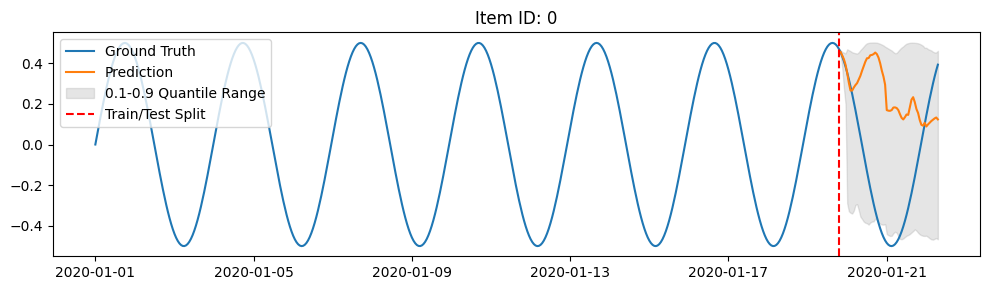

In [55]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf.loc[0:0],
    test=test_tsdf_ground_truth.loc[0:0],
    pred=pred.loc[0:0]
)

### Unused

--- snip ---- snip ---

In [52]:
X_train = torch.as_tensor(df_Train.loc[0:4].values, dtype=torch.float32)
X_test = torch.as_tensor(df_Test2.loc[0:4].values, dtype=torch.float32)
X_full = torch.cat([X_train, X_test], dim=0).unsqueeze(1)
y_train = torch.as_tensor(df_Test2.loc[0:4]['target'].values)
kw_args = {'save_peak_mem_factor': None}
y_pred = y_pred_reg.model_._forward(X_full, y_train, single_eval_pos=len(y_train), style=None) #, **kw_args)

In [57]:
y_pred.shape, X_full.shape

(torch.Size([2560, 1, 5000]), torch.Size([3040, 1, 12]))

In [49]:
for enc in y_pred_reg.model_.transformer_encoder.layers:
    enc.save_peak_mem_factor = None
#y_pred_reg.model_.transformer_encoder.layers[0].save_peak_mem_factor = None

In [ ]:
from tabpfn.utils import (
    _fix_dtypes,
    _get_ordinal_encoder,
    _transform_borders_one,
    infer_categorical_features,
    infer_device_and_type,
    infer_random_state,
    translate_probs_across_borders,
    update_encoder_outlier_params,
    validate_X_predict,
    validate_Xy_fit,
)
X = validate_X_predict(df_Test2.loc[0:1],y_pred_reg)
X = y_pred_reg.preprocessor_.transform(X)

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
std_borders = y_pred_reg.bardist_.borders.cpu().numpy()
outputs: list[torch.Tensor] = []
borders: list[np.ndarray] = []

In [ ]:
for output, config in y_pred_reg.executor_.iter_outputs(
            X,
            device=y_pred_reg.device_,
            autocast=y_pred_reg.use_autocast_,
        ):
    print(output)

In [ ]:
y_pred['mean'].shape, df_Test.loc[1].shape

In [ ]:
n=2
plt.plot(range(96), y_pred['median'][n*96:n*96+96]*100+1.2, label='pred')
plt.plot(df_Test.loc[n]['groundtruth'].values, label='gt')
plt.legend()

In [ ]:
y_pred_reg.model_

In [ ]:
#y_pred['mean']
test_tsdf.loc[0].shape
test_tsdf.loc[2]['target']

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(10,5))
ax[0].plot(y_pred['mean'])
ax[1].plot(test_tsdf.loc[0]['target'])


In [ ]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf.loc[0:1],
    test=test_tsdf.loc[0:1],
    pred=y_pred['mean']
)